# Diversity plots

Working figure caption:

Fig 1. Fecal transplant after antibiotics in IBD patients alters global community composition without affecting diversity. (a) 16S Alpha diversity by shannon and otu richness over time (b) PCoA of beta diversity based on 16S (c) PCoA of beta diversity based on metaphlan species (d) time series of beta diversity change from baseline (e) time series of beta diversity distance from donors

In [12]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div
import scipy.stats as stats
import skbio.stats.ordination as ordination
import skbio.stats as skstats

import matplotlib
from io import StringIO
from skbio import TreeNode
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

#set default font size
font = {'size': 10}
matplotlib.rc('font', **font)

# set default font
#matplotlib.rcParams['font.sans-serif'] = "Helvetica"
#matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [3]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [4]:
#read in 16S data
otu = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                  sep='\t', index_col=0).astype(int)
otu_rare = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f_rare8500.tsv',
                       sep='\t', index_col=0).astype(int)

In [10]:
#read in metagenomics
mtphl = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/metaphlan/deepdive_metaphlan_tax_abun.tsv.gz',
                    sep='\t', index_col=0)
#add taxa level
mtphl.loc[:, 'taxa_level'] = mtphl.index.str.count('\|') + 1

#get feature table
mtphl_sp = mtphl.loc[mtphl['taxa_level'] == 7]
mtphl_sp = mtphl_sp.reset_index().pivot(index='taxa', 
                                        columns='sample', 
                                        values='rel_abundance')
mtphl_sp = mtphl_sp.fillna(0)

In [6]:
#read in newick tree
with open('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/tree.nwk') as nwk:
    tree = TreeNode.read(StringIO(nwk.readlines()[0].rstrip()))

## Alpha diversity

### 16S

In [61]:
#calculate alpha diversity
shannon = otu_rare.apply(div.alpha.shannon).to_frame(name='shannon')
obs = otu_rare.apply(lambda x: x.astype(bool).sum()).to_frame(name='observed')

#merge with metadata
shannon = shannon.merge(md, left_index=True, right_on='sample_id')
obs = obs.merge(md, left_index=True, right_on='sample_id')

In [62]:
#get averages from donors
shannon_0044 = shannon.loc[shannon['patient'] == '0044']['shannon'].mean()
shannon_0073 = shannon.loc[shannon['patient'] == '0073']['shannon'].mean()

obs_0044 = obs.loc[obs['patient'] == '0044']['observed'].mean()
obs_0073 = obs.loc[obs['patient'] == '0073']['observed'].mean()

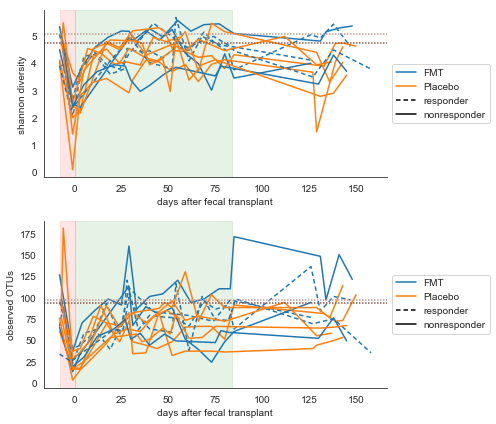

In [66]:
#plot alpha diversity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x='days_past_fmt', y='shannon',
                   hue='patient_plt', style='patient_plt',
                   data=shannon,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax1.set_ylabel('shannon diversity')
ax1.set_xlabel('days after fecal transplant')
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax1.axhline(shannon_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax1.axhline(shannon_0073, dashes=(1,1), color=dd_pat_col['0073'])

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x='days_past_fmt', y='observed',
                   hue='patient_plt', style='patient_plt',
                   data=obs,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax2.set_ylabel('observed OTUs')
ax2.set_xlabel('days after fecal transplant')
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax2.axhline(obs_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax2.axhline(obs_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_time_16S_NV022018.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_time_16S_NV022018.pdf',
            dpi=300)

### Metagenomics

We'll look at species-level alpha diversity

In [35]:
#calculate alpha diversity
shannon_mtphl = mtphl_sp.apply(stats.entropy, base=2).to_frame(name='shannon')
obs_mtphl = mtphl_sp.apply(lambda x: x.astype(bool).sum()).to_frame(name='observed')

#merge with metadata
shannon_mtphl = shannon_mtphl.merge(md, left_index=True, right_on='sample_id')
obs_mtphl = obs_mtphl.merge(md, left_index=True, right_on='sample_id')

In [36]:
#get averages from donors
shannon_mtphl_0044 = shannon_mtphl.loc[shannon_mtphl['patient'] == '0044']['shannon'].mean()
shannon_mtphl_0073 = shannon_mtphl.loc[shannon_mtphl['patient'] == '0073']['shannon'].mean()

obs_mtphl_0044 = obs_mtphl.loc[obs_mtphl['patient'] == '0044']['observed'].mean()
obs_mtphl_0073 = obs_mtphl.loc[obs_mtphl['patient'] == '0073']['observed'].mean()

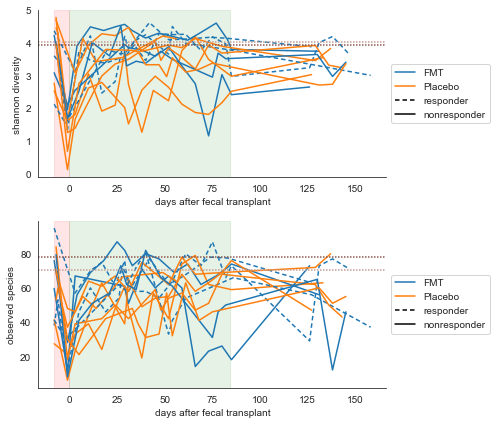

In [67]:
#plot alpha diversity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x='days_past_fmt', y='shannon',
                   hue='patient_plt', style='patient_plt',
                   data=shannon_mtphl,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax1.set_ylabel('shannon diversity')
ax1.set_xlabel('days after fecal transplant')
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax1.axhline(shannon_mtphl_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax1.axhline(shannon_mtphl_0073, dashes=(1,1), color=dd_pat_col['0073'])

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x='days_past_fmt', y='observed',
                   hue='patient_plt', style='patient_plt',
                   data=obs_mtphl,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax2.set_ylabel('observed species')
ax2.set_xlabel('days after fecal transplant')
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax2.axhline(obs_mtphl_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax2.axhline(obs_mtphl_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_time_mgx_NV022018.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_time_mgx_NV022018.pdf',
            dpi=300)

## PCoA of betadiversity

In [11]:
#get betadiversity
bray = dist.squareform(dist.pdist(otu_rare.T.values, metric='braycurtis'))
bray_mtphl = dist.squareform(dist.pdist(mtphl_sp.T.values, metric='braycurtis'))
#make these into dataframes
bray_df = pd.DataFrame(bray, columns=otu_rare.columns, index=otu_rare.columns)
bray_df_mtphl = pd.DataFrame(bray_mtphl, 
                             columns=mtphl_sp.columns, 
                             index=mtphl_sp.columns)

In [18]:
#calculate pcoa
pcoa_bray = ordination.pcoa(bray_df)
pcoa_bray_mtphl = ordination.pcoa(bray_df_mtphl)

#get pcoa results
pcoa_bray_coords = pcoa_bray.samples
pcoa_bray_mtphl_coords = pcoa_bray_mtphl.samples

#replace indexes
pcoa_bray_coords.index = bray_df.index
pcoa_bray_mtphl_coords.index = bray_df_mtphl.index

#add metadata to the dataframes
pcoa_bray_coords = pcoa_bray_coords.merge(md, left_index=True, 
                                          right_on='sample_id').sort_values('patient')
pcoa_bray_mtphl_coords = pcoa_bray_mtphl_coords.merge(md, left_index=True, 
                                                      right_on='sample_id').sort_values('patient')

#make a patient category that doesn't look like numbers for seaborn
pcoa_bray_coords.loc[:, 'patient'] = 'patient_' + pcoa_bray_coords['patient']
pcoa_bray_mtphl_coords.loc[:, 'patient'] = 'patient_' + pcoa_bray_mtphl_coords['patient']

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.24379121339448018 and the largest is 14.941464663310699.
  RuntimeWarning
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details

In [19]:
#write these pcoa results
pcoa_bray_coords.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/pcoa_16s_NV032018.tsv',
                        sep='\t', index=False)

pcoa_bray_mtphl_coords.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/pcoa_mtphl_NV032018.tsv',
                              sep='\t', index=False)

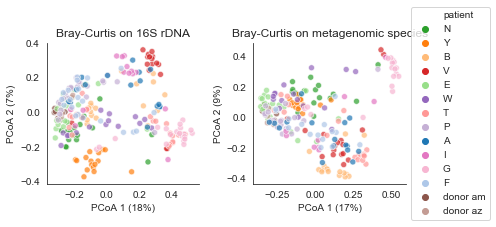

In [25]:
#plot these new pcoa points
hue_order = ['patient_001', 'patient_004', 'patient_005',
             'patient_006', 'patient_007', 'patient_008',
             'patient_009', 'patient_010', 'patient_011',
             'patient_012', 'patient_013', 'patient_014',
             'patient_0044', 'patient_0073']

fig = plt.figure(figsize = (7,3))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='PC1', y='PC2', hue='patient', data=pcoa_bray_coords,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('Bray-Curtis on 16S rDNA', fontsize=12)
ax1.legend_.remove()
ax1.set_xlabel('PCoA 1 (18%)', fontsize=10)
ax1.set_ylabel('PCoA 2 (7%)', fontsize=10)

ax3 = fig.add_subplot(1,2,2)
sns.scatterplot(x='PC1', y='PC2', hue='patient', data=pcoa_bray_mtphl_coords,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('Bray-Curtis on metagenomic species', fontsize=12)

#make the legend
legend = ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#get the patient IDs
patient_ids = md_pat.set_index('patient').to_dict()['id_pub']
patient_ids = {f'patient_{k}': v for k, v in patient_ids.items()}
#add the donors ids
patient_ids['patient_0044'] = 'donor am'
patient_ids['patient_0073'] = 'donor az'
#swap out the labels
for entry in legend.get_texts():
    if entry.get_text() in patient_ids:
        entry.set_text(patient_ids[entry.get_text()])

ax3.set_xlabel('PCoA 1 (17%)')
ax3.set_ylabel('PCoA 2 (9%)')

md_pat

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_mgx_2019-04-30.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_mgx_2019-04-30.pdf',
            dpi=300)

In [19]:
# get stats

bray_dm = skstats.distance.DistanceMatrix(bray, bray_df.columns)

#make dictionary of sample to patient
sam_to_pat = md.set_index('sample_id').to_dict()['patient']

#make dictionary of sample to patient v donor
sam_to_pvd = md.set_index('sample_id').to_dict()['patient_donor']

#permanova by patient
patient_grouping = [sam_to_pat[x] for x in bray_df.columns]
print(skstats.distance.permanova(bray_dm, patient_grouping))

#permanova of donors versus patients
donor_pat_grouping = [sam_to_pvd[x] for x in bray_df.columns]
print(skstats.distance.permanova(bray_dm, donor_pat_grouping))

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     235
number of groups                 15
test statistic              9.55549
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     235
number of groups                  3
test statistic              3.00064
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object


In [20]:
#permanova by patient
print(skstats.distance.anosim(bray_dm, patient_grouping))

#permanova of donors versus patients
print(skstats.distance.anosim(bray_dm, donor_pat_grouping))

method name                 ANOSIM
test statistic name              R
sample size                    235
number of groups                15
test statistic            0.455431
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
method name                ANOSIM
test statistic name             R
sample size                   235
number of groups                3
test statistic           -0.22709
p-value                         1
number of permutations        999
Name: ANOSIM results, dtype: object


# PCoA of unweighted unifrac

In [10]:
#get unqeighted unifrac
uf = pd.DataFrame()
uf = dist.squareform(dist.pdist(otu_rare.T.values, 
                                metric=div.beta.unweighted_unifrac,
                                otu_ids=otu_rare.index,
                                tree=tree))
#make these into dataframes
uf_df = pd.DataFrame(uf, columns=otu_rare.columns, index=otu_rare.columns)

In [13]:
#calculate pcoa
pcoa_uf = ordination.pcoa(uf_df)

#get pcoa results
pcoa_uf_coords = pcoa_uf.samples

#replace indexes
pcoa_uf_coords.index = uf_df.index

#add metadata to the dataframes
pcoa_uf_coords = pcoa_uf_coords.merge(md, left_index=True, 
                                      right_on='sample_id').sort_values('patient')

#make a patient category that doesn't look like numbers for seaborn
pcoa_uf_coords.loc[:, 'patient'] = 'patient_' + pcoa_uf_coords['patient']

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0641116815145639 and the largest is 7.613936170832192.
  RuntimeWarning


In [22]:
pcoa_uf.proportion_explained.head()

PC1    0.190376
PC2    0.096628
PC3    0.060261
PC4    0.054945
PC5    0.041973
dtype: float64

In [14]:
#write these pcoa results
pcoa_uf_coords.to_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/pcoa_16s_uf_2019-05-05.tsv',
                        sep='\t', index=False)

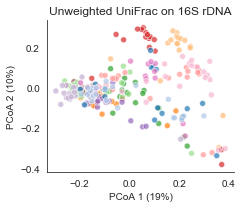

In [25]:
#plot these new pcoa points
hue_order = ['patient_001', 'patient_004', 'patient_005',
             'patient_006', 'patient_007', 'patient_008',
             'patient_009', 'patient_010', 'patient_011',
             'patient_012', 'patient_013', 'patient_014',
             'patient_0044', 'patient_0073']

fig = plt.figure(figsize = (3.5,3))

ax1 = fig.add_subplot(1,1,1)
sns.scatterplot(x='PC1', y='PC2', hue='patient', data=pcoa_uf_coords,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('Unweighted UniFrac on 16S rDNA', fontsize=12)
ax1.legend_.remove()
ax1.set_xlabel('PCoA 1 (19%)', fontsize=10)
ax1.set_ylabel('PCoA 2 (10%)', fontsize=10)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_uf_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_uf_2019-05-05.pdf',
            dpi=300)

## Mean bray-curtis distance from donor

In [32]:
#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get mean distance
mean_bray_donor = bray_df[sam_0044 + sam_0073].mean(axis=1)
mean_bray_mtphl_donor = bray_df_mtphl[sam_0044 + sam_0073].mean(axis=1)
#add metadata
mean_bray_donor = mean_bray_donor.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                     right_on='sample_id')
mean_bray_mtphl_donor = mean_bray_mtphl_donor.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                                 right_on='sample_id')

#get mean distances between donor samples
mean_bray_btw = [bray_df.loc[x, y] for x, y in itertools.product(sam_0044, sam_0073)]
mean_bray_btw = np.mean(mean_bray_btw)
mean_bray_mtphl_btw = [bray_df_mtphl.loc[x, y] for x, y in itertools.product(sam_0044, sam_0073)]
mean_bray_mtphl_btw = np.mean(mean_bray_mtphl_btw)

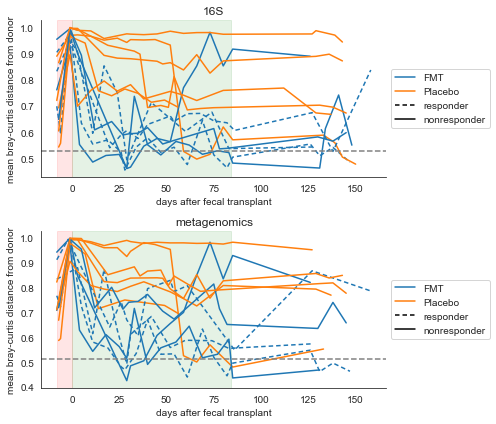

In [91]:
#plot donor similarity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=mean_bray_donor,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax1.set_ylabel('mean bray-curtis distance from donor')
ax1.set_xlabel('days after fecal transplant')
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add a line for the mean distance between donor samples
ax1.axhline(mean_bray_btw, color='grey', linestyle='dashed')
ax1.set_title('16S')

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=mean_bray_mtphl_donor,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax2.set_ylabel('mean bray-curtis distance from donor')
ax2.set_xlabel('days after fecal transplant')
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add a line for the mean distance between donor samples
ax2.axhline(mean_bray_mtphl_btw, color='grey', linestyle='dashed')
ax2.set_title('metagenomics')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/donor_dist_NV022018.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/donor_dist_NV022018.pdf',
            dpi=300)

In [113]:
#get mean distance from induction donor
donor_sam_dict = {'0044': sam_0044, '0073': sam_0073}

bray_ind = []
bray_mtphl_ind = []

for patient, sub_df in md.loc[md['sample_id'].isin(bray_df.columns)].groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    elif 'placebo' in sub_df['treatment'].values:
        continue
    
    donor = sub_df['fmt_induction'].iloc[0]
    donor_sam = donor_sam_dict[donor]
    sam = sub_df['sample_id'].tolist()
    
    mean_bray_ind = bray_df.loc[sam, donor_sam].mean(axis=1)
    mean_bray_mtphl_ind = bray_df_mtphl.loc[sam, donor_sam].mean(axis=1)
    
    #add metadata
    mean_bray_ind = mean_bray_ind.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                     right_on='sample_id')
    mean_bray_mtphl_ind = mean_bray_mtphl_ind.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                                 right_on='sample_id')
    
    bray_ind.append(mean_bray_ind)
    bray_mtphl_ind.append(mean_bray_mtphl_ind)

bray_ind = pd.concat(bray_ind)
bray_mtphl_ind = pd.concat(bray_mtphl_ind)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


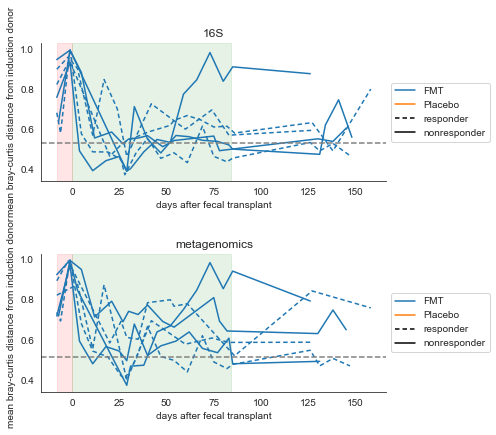

In [115]:
#plot donor similarity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=bray_ind,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax1.set_ylabel('mean bray-curtis distance from induction donor')
ax1.set_xlabel('days after fecal transplant')
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add a line for the mean distance between donor samples
ax1.axhline(mean_bray_btw, color='grey', linestyle='dashed')
ax1.set_title('16S')

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=bray_mtphl_ind,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax2.set_ylabel('mean bray-curtis distance from induction donor')
ax2.set_xlabel('days after fecal transplant')
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add a line for the mean distance between donor samples
ax2.axhline(mean_bray_mtphl_btw, color='grey', linestyle='dashed')
ax2.set_title('metagenomics')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/donor_dist_NV022018.png',
#            dpi=300)
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/donor_dist_NV022018.pdf',
#            dpi=300)

## Mean bray-curtis distance from baseline

In [54]:
#go through for each patient
bray_bl = []
bray_mtphl_bl = []

for patient, sub_df in md.loc[md['sample_id'].isin(bray_df.columns)].groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    
    bl_sam = sub_df.loc[sub_df['days_past_fmt'] < -5]['sample_id'].tolist()
    sam = sub_df['sample_id'].tolist()
    
    mean_bray_bl = bray_df.loc[sam, sam][bl_sam].mean(axis=1)
    mean_bray_mtphl_bl = bray_df_mtphl.loc[sam, sam][bl_sam].mean(axis=1)
    
    #add metadata
    mean_bray_bl = mean_bray_bl.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                   right_on='sample_id')
    mean_bray_mtphl_bl = mean_bray_mtphl_bl.to_frame(name='bray_curtis').merge(md, left_index=True,
                                                                               right_on='sample_id')
    
    bray_bl.append(mean_bray_bl)
    bray_mtphl_bl.append(mean_bray_mtphl_bl)

bray_bl = pd.concat(bray_bl)
bray_mtphl_bl = pd.concat(bray_mtphl_bl)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


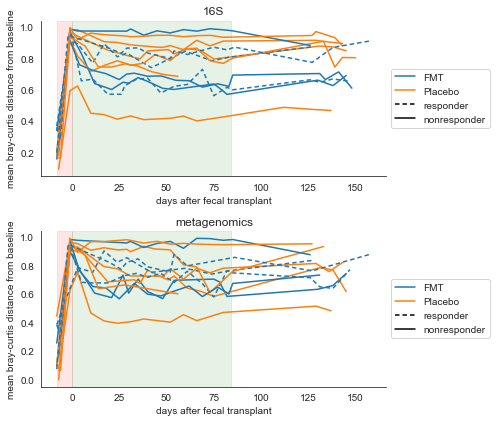

In [102]:
#plot donor similarity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=bray_bl,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax1.set_ylabel('mean bray-curtis distance from baseline')
ax1.set_xlabel('days after fecal transplant')
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
ax1.set_title('16S')

ax2 = fig.add_subplot(2,1,2)
ax2 = sns.lineplot(x='days_past_fmt', y='bray_curtis',
                   hue='patient_plt', style='patient_plt',
                   data=bray_mtphl_bl,
                   palette=dd_pat_treat_name,
                   dashes=dd_pat_dash_name,
                   ci=None)
#label axes
ax2.set_ylabel('mean bray-curtis distance from baseline')
ax2.set_xlabel('days after fecal transplant')
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
ax2.set_title('metagenomics')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='FMT'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='responder'),
                   Line2D([0], [0], color='black', dashes=(), label='nonresponder')]
ax1.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))
ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/baseline_dist_NV032018.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/baseline_dist_NV032018.pdf',
            dpi=300)

# Collapse into 5-day windows

### Alpha diversity

In [28]:
#let's get simply smash everything into 5-day windows
shannon_window_mean_dfs = []
for patient, sub_df in shannon.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['shannon']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'shannon': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['shannon']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['shannon'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    shannon_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

shannon_window_mean_df = pd.concat(shannon_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
shannon_window_mean_df = shannon_window_mean_df.merge(tmp_md)

In [41]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in shannon_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['shannon'], placebo['shannon'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

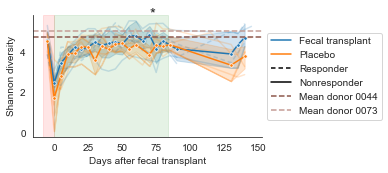

In [33]:
# for each patient, plot the alpha diveristy over time

fig = plt.figure(figsize = (5.5,2.5))

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in shannon_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

#get mean abundance for each donor
shannon_mean_0044 = shannon.loc[shannon['patient'] == '0044']['shannon'].mean()
shannon_mean_0073 = shannon.loc[shannon['patient'] == '0073']['shannon'].mean()

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=shannon_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Shannon diversity')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(shannon_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(shannon_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 5.7), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_2019-04-30.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_2019-04-30.pdf',
            dpi=300)

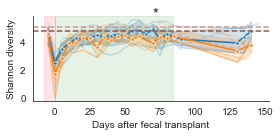

In [42]:
# PLOT NO LEGEND

fig = plt.figure(figsize = (4,2))

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in shannon_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

#get mean abundance for each donor
shannon_mean_0044 = shannon.loc[shannon['patient'] == '0044']['shannon'].mean()
shannon_mean_0073 = shannon.loc[shannon['patient'] == '0073']['shannon'].mean()

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=shannon_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Shannon diversity')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(shannon_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(shannon_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 5.7), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_nolgnd_2019-05-01.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_nolgnd_2019-05-01.pdf',
            dpi=300)

In [64]:
#let's get simply smash everything into 5-day windows for richness
obs_window_mean_dfs = []
for patient, sub_df in obs.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['observed']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'shannon': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['observed']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['observed'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    obs_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

obs_window_mean_df = pd.concat(obs_window_mean_dfs)

In [65]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
obs_window_mean_df = obs_window_mean_df.merge(tmp_md)

In [68]:
#Do T-test for each data point
ttest_res_obs = []
for time, sub_df in obs_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['observed'], placebo['observed'])
    ttest_res_obs.append([time, *t_res])
ttest_res_obs = pd.DataFrame(ttest_res_obs, columns=['chunk_time', 't_stat', 'p'])

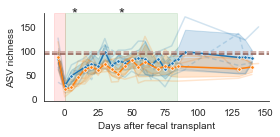

In [71]:
# PLOT NO LEGEND

fig = plt.figure(figsize = (4,2))

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in obs_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

#get mean abundance for each donor
obs_mean_0044 = obs.loc[obs['patient'] == '0044']['observed'].mean()
obs_mean_0073 = obs.loc[obs['patient'] == '0073']['observed'].mean()

ax = sns.lineplot(x='chunk_time', y='observed',
                  data=obs_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='observed',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('ASV richness')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(obs_mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(obs_mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_obs.loc[ttest_res_obs['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 170), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_richness_windows_nolgnd_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_richness_windows_nolgnd_2019-05-05.pdf',
            dpi=300)

### Betadiv from donor

In [34]:
#let's get simply smash everything into 5-day windows
bray_donor_window_mean_dfs = []
for patient, sub_df in mean_bray_donor.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'bray_curtis': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['bray_curtis'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    bray_donor_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

bray_donor_window_mean_df = pd.concat(bray_donor_window_mean_dfs)

In [35]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
bray_donor_window_mean_df = bray_donor_window_mean_df.merge(tmp_md)

In [54]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in bray_donor_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['bray_curtis'], placebo['bray_curtis'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

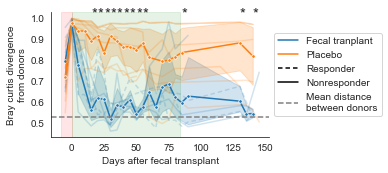

In [37]:
# for each patient, plot the total butyrate cluster counts over time

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_donor_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_donor_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence\nfrom donors')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean distance between the donor samples
ax.axhline(mean_bray_btw, color='grey', linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal tranplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color='grey', linestyle='dashed', 
                          label='Mean distance\nbetween donors')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_2019-04-10.pdf',
            dpi=300)

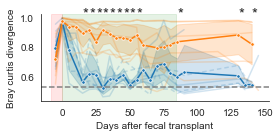

In [55]:
# PLOT NO LEGEND

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_donor_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (4,2))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_donor_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean distance between the donor samples
ax.axhline(mean_bray_btw, color='grey', linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_nolgnd_2019-05-01.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_nolgnd_2019-05-01.pdf',
            dpi=300)

### Distance from baseline

In [46]:
#let's get simply smash everything into 5-day windows
bray_bl_window_mean_dfs = []
for patient, sub_df in bray_bl.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'bray_curtis': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['bray_curtis'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    bray_bl_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

bray_bl_window_mean_df = pd.concat(bray_bl_window_mean_dfs)

In [47]:
#get mean distance between within donor samples
mean_bray_win_0044 = [bray_df.loc[x, y] for x, y in itertools.combinations(sam_0044, 2)]
mean_bray_win_0073 = [bray_df.loc[x, y] for x, y in itertools.combinations(sam_0073, 2)]
mean_bray_win_0044 = np.mean(mean_bray_win_0044)
mean_bray_win_0073 = np.mean(mean_bray_win_0073)

In [48]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
bray_bl_window_mean_df = bray_bl_window_mean_df.merge(tmp_md)

In [49]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in bray_bl_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['bray_curtis'], placebo['bray_curtis'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

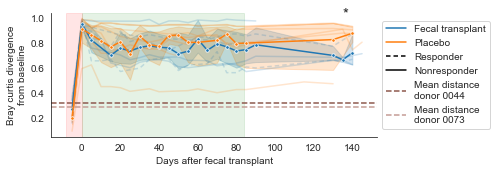

In [50]:
# for each patient, plot beta diversity from baseline

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_bl_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_bl_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence\nfrom baseline')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_bray_win_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_bray_win_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean distance\ndonor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean distance\ndonor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_2019-04-10.pdf',
            dpi=300)

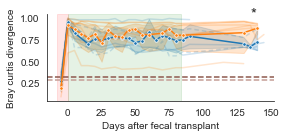

In [52]:
# PLOT NO LEGEND

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_bl_window_mean_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (4,2))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_bl_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_bray_win_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_bray_win_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_nolgnd_2019-05-01.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_nolgnd_2019-05-01.pdf',
            dpi=300)

## Mean distance to other patients

Do FMT samples converge and placebo patients diverge?

Could use either PCoA space or Bray-curtis distance space.

In [180]:
#let's look at a few different time periods
periods = [['baseline', [-10, -5]], ['antibiotics', [-2, 1]],
           ['week_4', [25, 35]], ['week_8', [50, 60]],
           ['week_12', [80, 90]], ['week_18', [120, 140]]]

In [189]:
tmp_md = md.loc[md['sample_id'].isin(bray_df.columns)]
period_res = []
for period in periods:
    #get information for fmt samples
    fmt_df = tmp_md.loc[(tmp_md['days_past_fmt'].between(*period[1])) &\
                        (tmp_md['treatment'] == 'fmt')]
    plc_df = tmp_md.loc[(tmp_md['days_past_fmt'].between(*period[1])) &\
                        (tmp_md['treatment'] == 'placebo')]
    
    #get samples sets
    fmt_sets = [[pat, x['sample_id'].tolist()] \
                for pat, x in fmt_df.groupby('patient')]
    plc_sets = [[pat, x['sample_id'].tolist()] \
                for pat, x in plc_df.groupby('patient')]
    
    #for each of these sets, get mean distance to all other patients
    res_fmt = []
    for s_set in fmt_sets:
        other_sets = [x for x in fmt_sets if x != s_set]
        for other_set in other_sets:
            dists = [bray_df.loc[x, y] \
                     for x, y in itertools.product(s_set[1], other_set[1])]
            mean_dist = np.mean(dists)
            period_res.append([s_set[0], other_set[0], mean_dist,
                              'fmt', period[0]])
    
    res_plc = []
    for s_set in plc_sets:
        other_sets = [x for x in plc_sets if x != s_set]
        for other_set in other_sets:
            dists = [bray_df.loc[x, y] \
                     for x, y in itertools.product(s_set[1], other_set[1])]
            mean_dist = np.mean(dists)
            period_res.append([s_set[0], other_set[0], mean_dist,
                              'placebo', period[0]])
    
#make a final dataframe of these results
period_res_df = pd.DataFrame(period_res, 
                             columns=['patient_a', 'patient_b',
                                      'bray_curtis', 'treatment', 'period'])

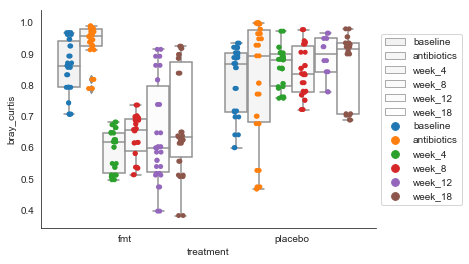

In [200]:
ax = sns.stripplot(x='treatment', y='bray_curtis',
              hue='period', data=period_res_df,
              dodge=True)
ax = sns.boxplot(x='treatment', y='bray_curtis',
              hue='period', data=period_res_df,
              dodge=True, color='white')
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()

In [203]:
period_res_df_mean = period_res_df.groupby(['patient_a', 'treatment', 'period']).mean()
period_res_df_mean = period_res_df_mean.reset_index()

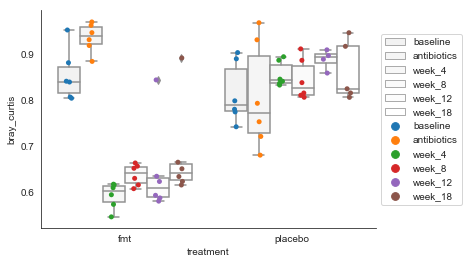

In [211]:
grp_order = ['baseline', 'antibiotics', 'week_4',
             'week_8', 'week_12', 'week_18']
ax = sns.stripplot(x='treatment', y='bray_curtis',
              hue='period', data=period_res_df_mean,
              dodge=True, hue_order=grp_order)
ax = sns.boxplot(x='treatment', y='bray_curtis',
              hue='period', data=period_res_df_mean,
              dodge=True, color='white', hue_order=grp_order)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

sns.despine()

In [220]:
#get ttests between all sets
groups = [[group, sub_df] for group, sub_df in period_res_df_mean.groupby(['treatment', 'period'])]

ttest_mean_res = []
for a, b in itertools.combinations(groups, 2):
    ttest = stats.ttest_ind(a[1]['bray_curtis'], b[1]['bray_curtis'])
    ttest_mean_res.append([a[0][0], a[0][1], 
                           b[0][0], b[0][1],
                           ttest[0], ttest[1]])
ttest_mean_res_df = pd.DataFrame(ttest_mean_res,
                                 columns=['group1_treatment', 'group1_period',
                                          'group2_treatment', 'group2_period',
                                          't_stat', 'p'])

## Window collapse for MGX species

In [41]:
#let's get simply smash everything into 5-day windows
shannon_window_mean_mgx_dfs = []
for patient, sub_df in shannon_mtphl.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['shannon']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'shannon': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['shannon']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['shannon'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    shannon_window_mean_mgx_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

shannon_window_mean_mgx_df = pd.concat(shannon_window_mean_mgx_dfs)

In [42]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
shannon_window_mean_mgx_df = shannon_window_mean_mgx_df.merge(tmp_md)

In [44]:
#Do T-test for each data point
ttest_res_shannon_mgx = []
for time, sub_df in shannon_window_mean_mgx_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['shannon'], placebo['shannon'])
    ttest_res_shannon_mgx.append([time, *t_res])
ttest_res_shannon_mgx = pd.DataFrame(ttest_res_shannon_mgx, 
                                     columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


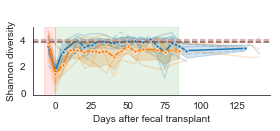

In [47]:
# PLOT NO LEGEND

fig = plt.figure(figsize = (4,2))

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in shannon_window_mean_mgx_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

#get mean abundance for each donor
shannon_mean_mgx_0044 = shannon_mtphl.loc[shannon_mtphl['patient'] == '0044']['shannon'].mean()
shannon_mean_mgx_0073 = shannon_mtphl.loc[shannon_mtphl['patient'] == '0073']['shannon'].mean()

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=shannon_window_mean_mgx_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='shannon',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Shannon diversity')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(shannon_mean_mgx_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(shannon_mean_mgx_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_shannon_mgx.loc[ttest_res_shannon_mgx['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 5.7), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_nolgnd_mgx_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_shannon_windows_nolgnd_mgx_2019-05-05.pdf',
            dpi=300)

In [49]:
#let's get simply smash everything into 5-day windows
bray_donor_window_mgx_dfs = []
for patient, sub_df in mean_bray_mtphl_donor.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'bray_curtis': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['bray_curtis'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    bray_donor_window_mgx_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

bray_donor_window_mgx_df = pd.concat(bray_donor_window_mgx_dfs)

In [50]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
bray_donor_window_mgx_df = bray_donor_window_mgx_df.merge(tmp_md)

In [51]:
#Do T-test for each data point
ttest_res_bray_donor_mgx = []
for time, sub_df in bray_donor_window_mgx_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['bray_curtis'], placebo['bray_curtis'])
    ttest_res_bray_donor_mgx.append([time, *t_res])
ttest_res_bray_donor_mgx = pd.DataFrame(ttest_res_bray_donor_mgx, 
                                        columns=['chunk_time', 't_stat', 'p'])

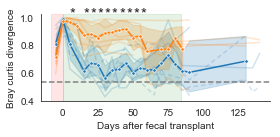

In [53]:
# PLOT NO LEGEND

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_donor_window_mgx_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (4,2))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_donor_window_mgx_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean distance between the donor samples
ax.axhline(mean_bray_btw, color='grey', linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_bray_donor_mgx.loc[ttest_res_bray_donor_mgx['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_mgx_nolgnd_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_donor_windows_mgx_nolgnd_2019-05-05.pdf',
            dpi=300)

In [55]:
#let's get simply smash everything into 5-day windows
bray_bl_window_mgx_dfs = []
for patient, sub_df in bray_mtphl_bl.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'bray_curtis': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['bray_curtis']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['bray_curtis'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    bray_bl_window_mgx_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

bray_bl_window_mgx_df = pd.concat(bray_bl_window_mgx_dfs)

In [56]:
#get mean distance between within donor samples
mean_bray_mgx_win_0044 = [bray_df_mtphl.loc[x, y] for x, y in itertools.combinations(sam_0044, 2)]
mean_bray_mgx_win_0073 = [bray_df_mtphl.loc[x, y] for x, y in itertools.combinations(sam_0073, 2)]
mean_bray_mgx_win_0044 = np.mean(mean_bray_mgx_win_0044)
mean_bray_mgx_win_0073 = np.mean(mean_bray_mgx_win_0073)

In [57]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
bray_bl_window_mgx_df = bray_bl_window_mgx_df.merge(tmp_md)

In [58]:
#Do T-test for each data point
ttest_res_bl_mgx = []
for time, sub_df in bray_bl_window_mgx_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['bray_curtis'], placebo['bray_curtis'])
    ttest_res_bl_mgx.append([time, *t_res])
ttest_res_bl_mgx = pd.DataFrame(ttest_res_bl_mgx, columns=['chunk_time', 't_stat', 'p'])

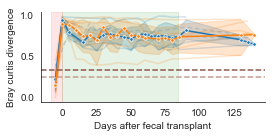

In [59]:
# PLOT NO LEGEND

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in bray_bl_window_mgx_df.groupby(['treatment',
                                                                      'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (4,2))

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=bray_bl_window_mgx_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='bray_curtis',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Bray curtis divergence')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_bray_mgx_win_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_bray_mgx_win_0073, color=dd_pat_col['0073'], linestyle='dashed')

#make legends for both plots
ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_bl_mgx.loc[ttest_res_bl_mgx['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 1.0), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_mgx_nolgnd_2019-05-01.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/bray_bl_windows_mgx_nolgnd_2019-05-01.pdf',
            dpi=300)

In [ ]:
obs_mtphl

In [74]:
#let's get simply smash everything into 5-day windows
obs_window_mean_mgx_dfs = []
for patient, sub_df in obs_mtphl.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['observed']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'observed': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['observed']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['observed'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    obs_window_mean_mgx_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

obs_window_mean_mgx_df = pd.concat(obs_window_mean_mgx_dfs)

In [75]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
obs_window_mean_mgx_df = obs_window_mean_mgx_df.merge(tmp_md)

In [77]:
#Do T-test for each data point
ttest_res_obs_mgx = []
for time, sub_df in obs_window_mean_mgx_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['observed'], placebo['observed'])
    ttest_res_obs_mgx.append([time, *t_res])
ttest_res_obs_mgx = pd.DataFrame(ttest_res_obs_mgx, 
                                     columns=['chunk_time', 't_stat', 'p'])

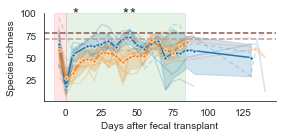

In [80]:
# PLOT NO LEGEND

fig = plt.figure(figsize = (4,2))

#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in obs_window_mean_mgx_df.groupby(['treatment',
                                                                          'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

#get mean abundance for each donor
obs_mean_mgx_0044 = obs_mtphl.loc[obs_mtphl['patient'] == '0044']['observed'].mean()
obs_mean_mgx_0073 = obs_mtphl.loc[obs_mtphl['patient'] == '0073']['observed'].mean()

ax = sns.lineplot(x='chunk_time', y='observed',
                  data=obs_window_mean_mgx_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='observed',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Species richness')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(obs_mean_mgx_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(obs_mean_mgx_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_obs_mgx.loc[ttest_res_obs_mgx['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 95), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_obs_windows_nolgnd_mgx_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/alpha_obs_windows_nolgnd_mgx_2019-05-05.pdf',
            dpi=300)